# INTRODUCTION

# DATA EXPLORATION    
## Setup

In [105]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from statistics import mean
import joblib 

## Loading the data

In [106]:
raw_data = pd.read_csv(r'c:\Users\locha\AI\ASM3\global_bleaching_environmental.csv')
raw_data.head()

C:\Users\locha\AppData\Local\Temp\ipykernel_25192\111959839.py:1: DtypeWarning: Columns (13,15,24) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r'c:\Users\locha\AI\ASM3\global_bleaching_environmental.csv')


,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Reef_ID,Realm_Name,Ecoregion_Name,Country_Name,...,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Date,Site_Comments,Sample_Comments,Bleaching_Comments
0,2501,10324336,Donner,23.163,-82.5260,Atlantic,nd,Tropical Atlantic,Cuba and Cayman Islands,Cuba,...,5,0,0,0.74,7.25,0.18,2005-09-15,nd,nd,nd
1,3467,10324754,Donner,-17.575,-149.7833,Pacific,nd,Eastern Indo-Pacific,Society Islands French Polynesia,French Polynesia,...,4,0,0.26,0.67,4.65,0.19,1991-03-15,The bleaching does not appear to have gained ...,The bleaching does not appear to have gained ...,nd
2,1794,10323866,Donner,18.369,-64.5640,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United Kingdom,...,7,0,0,1.04,11.66,0.26,2006-01-15,nd,nd,nd
3,8647,10328028,Donner,17.760,-64.5680,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,4,0,0,0.75,5.64,0.2,2006-04-15,nd,nd,nd
4,8648,10328029,Donner,17.769,-64.5830,Atlantic,nd,Tropical Atlantic,Hispaniola Puerto Rico and Lesser Antilles,United States,...,5,0,0,0.92,6.89,0.25,2006-04-15,nd,nd,nd


## First inspection

In [107]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site_ID                                41361 non-null  int64  
 1   Sample_ID                              41361 non-null  int64  
 2   Data_Source                            41361 non-null  object 
 3   Latitude_Degrees                       41361 non-null  float64
 4   Longitude_Degrees                      41361 non-null  float64
 5   Ocean_Name                             41361 non-null  object 
 6   Reef_ID                                41361 non-null  object 
 7   Realm_Name                             41361 non-null  object 
 8   Ecoregion_Name                         41361 non-null  object 
 9   Country_Name                           41361 non-null  object 
 10  State_Island_Province_Name             41361 non-null  object 
 11  Ci

Because our dataset has a large number of features, we have decided to drop several columns and keep the essential ones for Exploratory Data Analysis (EDA) for a more efficient analysis.
Here are the features we deemed essential:
- **Latitude_Degrees**: Y-axis coordinates.
- **Longtitude_Degrees**: X-axis coordinates.
- **Ocean_Name**: The ocean which the sample came from.
- **Realm_Name**: The realm of the coral, defined by the Marine Ecoregions of the World (MEOW).
- **Distance_to_Shore**: Distance of sample from nearest land.
- **Exposure**: In layman's terms, how exposed were the coral to wind, whether strong or prevailing.
- **Cyclone_Frequency**: How frequent the coral has to deal with cyclones.
- **Depth_m**: Depth(m) of sampling site.
- **Percent_Cover**: The percentage of the reef covered in coral.
- **Bleaching_Level**: Reef Check data, coral population or coral colony.
- **Percent_Bleaching**: Percentage of samples affected by bleadching.
- **ClimSST**: Climatological Sea-surface Temperature (SST), based on weekly measurements of SSTs on samples.
- **Temperature_Mean**: The average SST in degrees Celsius.
- **Temperature_Maximum**: The maximum SST in degrees Celsius.
- **Temperature_Kelvin**: The SST in degrees Kelvin, for easier comparison.
- **Windspeed**: In meters-per-hour, coupled with 'Exposure' feature.
- **SSTA**: Sea-surface Temperature Anomaly, weekly SST minus weekly ClimSST, calculated in Celsius. 
- **SSTA_DHW**: SSTA Degree Heating Weeks, sum of the previous 12 weeks when SSTA >= 1 degrees Celsius.
- **Date**: The date of which samples were collected

In [108]:
#Drop all features not listed above.
raw_data.drop(columns = [
    "Site_ID", "Sample_ID", "Data_Source", "Reef_ID", 
    "Realm_Name", "Country_Name", "Ecoregion_Name",
    "State_Island_Province_Name",
    "City_Town_Name", "Site_Name",
    "Date_Day", "Date_Month", "Date_Year",
    "Substrate_Name", "Turbidity",
    "Temperature_Kelvin_Standard_Deviation", "Temperature_Minimum",
    "SSTA_Standard_Deviation", "SSTA_Mean", "SSTA_Minimum", "SSTA_Maximum",
    "SSTA_DHW_Standard_Deviation", "SSTA_DHWMax", "SSTA_DHWMean", 
    "SSTA_Frequency", "SSTA_Frequency_Standard_Deviation", "SSTA_FrequencyMax", "SSTA_FrequencyMean",
    "TSA", "TSA_Standard_Deviation", "TSA_Minimum", "TSA_Maximum",
    "TSA_Frequency_Standard_Deviation", "TSA_FrequencyMax", "TSA_FrequencyMean",
    "TSA_DHW", "TSA_DHW_Standard_Deviation", "TSA_DHWMax", "TSA_DHWMean", 
    "Site_Comments", "Sample_Comments", "Bleaching_Comments"
], inplace=True) 

In [109]:
#Double checking
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude_Degrees     41361 non-null  float64
 1   Longitude_Degrees    41361 non-null  float64
 2   Ocean_Name           41361 non-null  object 
 3   Distance_to_Shore    41361 non-null  object 
 4   Exposure             41361 non-null  object 
 5   Cyclone_Frequency    41361 non-null  float64
 6   Depth_m              41361 non-null  object 
 7   Percent_Cover        41361 non-null  object 
 8   Bleaching_Level      41361 non-null  object 
 9   Percent_Bleaching    41361 non-null  object 
 10  ClimSST              41361 non-null  object 
 11  Temperature_Kelvin   41361 non-null  object 
 12  Temperature_Mean     41361 non-null  object 
 13  Temperature_Maximum  41361 non-null  object 
 14  Windspeed            41361 non-null  object 
 15  SSTA                 41361 non-null 

## Handling missing values
The feature "Percent_Bleaching", which is our main feature, has many values reported as 'nd' which might obscure your models. Therefore, we have elected to remove all rows containg 'nd' in the "Percent_Bleaching" column.

In [110]:
df_clean = raw_data[raw_data['Percent_Bleaching'] != 'nd']
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34515 entries, 0 to 35044
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude_Degrees     34515 non-null  float64
 1   Longitude_Degrees    34515 non-null  float64
 2   Ocean_Name           34515 non-null  object 
 3   Distance_to_Shore    34515 non-null  object 
 4   Exposure             34515 non-null  object 
 5   Cyclone_Frequency    34515 non-null  float64
 6   Depth_m              34515 non-null  object 
 7   Percent_Cover        34515 non-null  object 
 8   Bleaching_Level      34515 non-null  object 
 9   Percent_Bleaching    34515 non-null  object 
 10  ClimSST              34515 non-null  object 
 11  Temperature_Kelvin   34515 non-null  object 
 12  Temperature_Mean     34515 non-null  object 
 13  Temperature_Maximum  34515 non-null  object 
 14  Windspeed            34515 non-null  object 
 15  SSTA                 34515 non-null  obje

Due to compatability issues with Pandas, I have elected to convert the features to either Numerical or Categorical values. 

In [111]:
To_Numeric = ['Latitude_Degrees', 'Longitude_Degrees',
              'Distance_to_Shore', 'Percent_Bleaching', 
              'Depth_m', 'ClimSST',
              'Temperature_Kelvin', 'Temperature_Mean', 
              'Temperature_Maximum', 'Windspeed',
              'SSTA', 'SSTA_DHW', 'TSA_Mean', 'TSA_Frequency'
              ] #Features that needs changing
for column in To_Numeric:
    df_clean[column] = pd.to_numeric(df_clean[column], errors='coerce') #Force all errors into NaN value.

#Double checking.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34515 entries, 0 to 35044
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude_Degrees     34515 non-null  float64
 1   Longitude_Degrees    34515 non-null  float64
 2   Ocean_Name           34515 non-null  object 
 3   Distance_to_Shore    34513 non-null  float64
 4   Exposure             34515 non-null  object 
 5   Cyclone_Frequency    34515 non-null  float64
 6   Depth_m              32834 non-null  float64
 7   Percent_Cover        34515 non-null  object 
 8   Bleaching_Level      34515 non-null  object 
 9   Percent_Bleaching    34515 non-null  float64
 10  ClimSST              34420 non-null  float64
 11  Temperature_Kelvin   34393 non-null  float64
 12  Temperature_Mean     34409 non-null  float64
 13  Temperature_Maximum  34409 non-null  float64
 14  Windspeed            34404 non-null  float64
 15  SSTA                 34393 non-null  floa

C:\Users\locha\AppData\Local\Temp\ipykernel_25192\2572048226.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = pd.to_numeric(df_clean[column], errors='coerce') #Force all errors into NaN value.


In [112]:
To_Categorical = ['Ocean_Name', 'Exposure', 'Bleaching_Level']

for column in To_Categorical:
    df_clean[column] = df_clean[column].astype('category')

#Double checking.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34515 entries, 0 to 35044
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Latitude_Degrees     34515 non-null  float64 
 1   Longitude_Degrees    34515 non-null  float64 
 2   Ocean_Name           34515 non-null  category
 3   Distance_to_Shore    34513 non-null  float64 
 4   Exposure             34515 non-null  category
 5   Cyclone_Frequency    34515 non-null  float64 
 6   Depth_m              32834 non-null  float64 
 7   Percent_Cover        34515 non-null  object  
 8   Bleaching_Level      34515 non-null  category
 9   Percent_Bleaching    34515 non-null  float64 
 10  ClimSST              34420 non-null  float64 
 11  Temperature_Kelvin   34393 non-null  float64 
 12  Temperature_Mean     34409 non-null  float64 
 13  Temperature_Maximum  34409 non-null  float64 
 14  Windspeed            34404 non-null  float64 
 15  SSTA                 343

C:\Users\locha\AppData\Local\Temp\ipykernel_25192\2761736600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = df_clean[column].astype('category')
C:\Users\locha\AppData\Local\Temp\ipykernel_25192\2761736600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = df_clean[column].astype('category')
C:\Users\locha\AppData\Local\Temp\ipykernel_25192\2761736600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

## EDA (Exploratory data analysis) 

In [113]:
print(df_clean.describe())

       Latitude_Degrees  Longitude_Degrees  Distance_to_Shore  \
count      34515.000000       34515.000000       34513.000000   
mean           7.990922          27.393375        3672.014658   
std           15.803601         104.639914       13384.497461   
min          -28.864500        -179.859400           3.200000   
25%           -3.874200         -80.089700         126.240000   
50%           11.287900          56.364100         476.030000   
75%           20.408000         119.773100        1836.530000   
max           36.750000         179.964500      299218.500000   

       Cyclone_Frequency       Depth_m  Percent_Bleaching       ClimSST  \
count       34515.000000  32834.000000       34515.000000  34420.000000   
mean           52.325062      7.052727           9.619465    294.173526   
std             7.597484      4.233982          20.190956     14.793875   
min            18.310000      0.000000           0.000000    262.150000   
25%            47.940000      4.000000 

### Further analysis of features.

**Visualisation** of features compared to Percent_Bleaching.

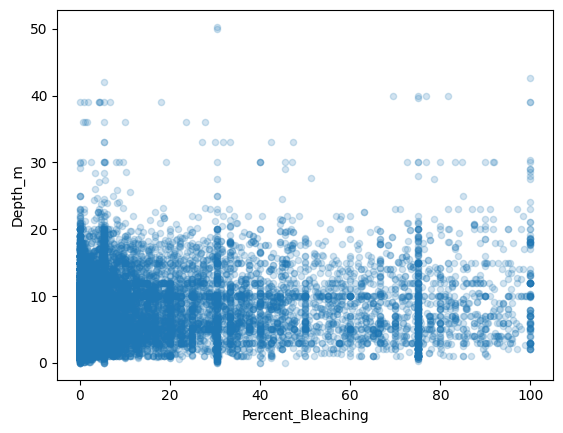

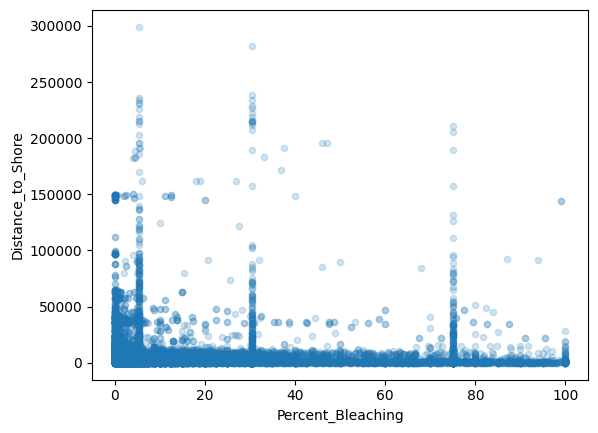

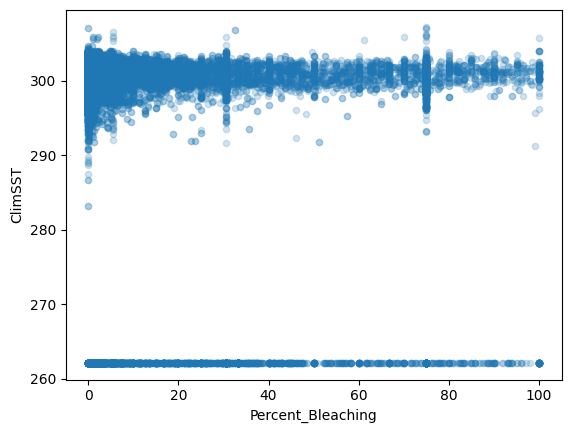

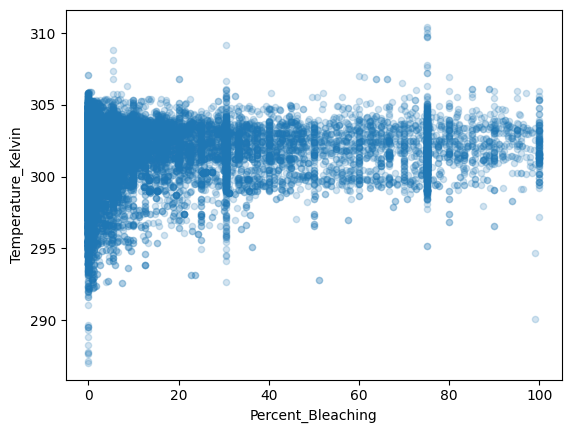

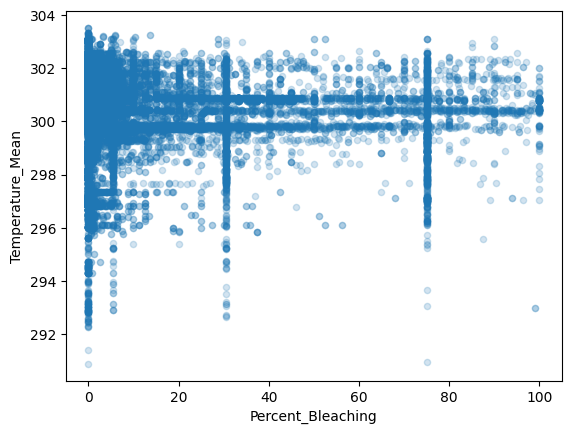

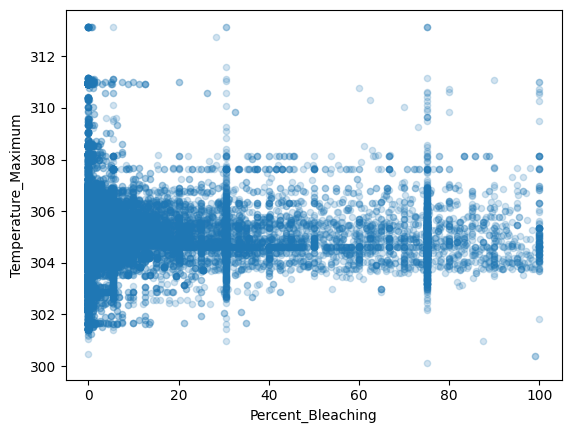

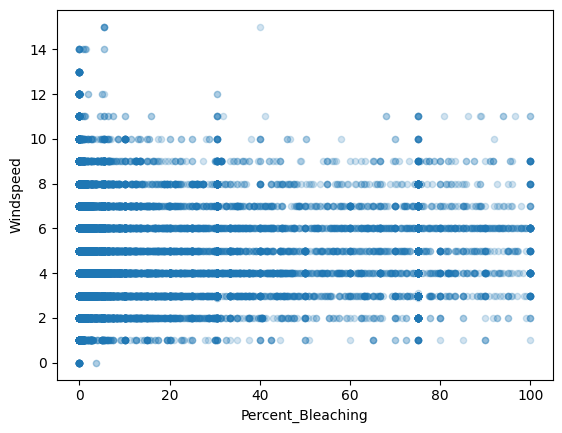

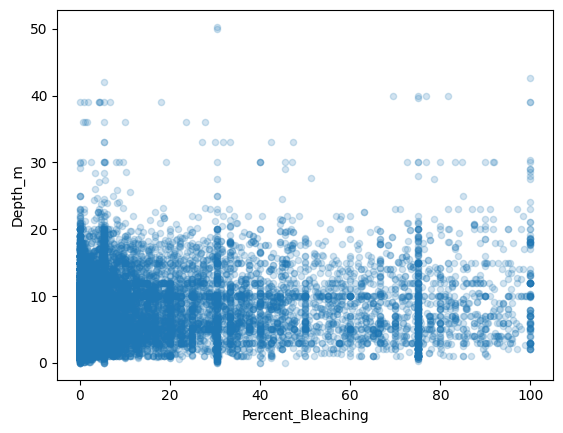

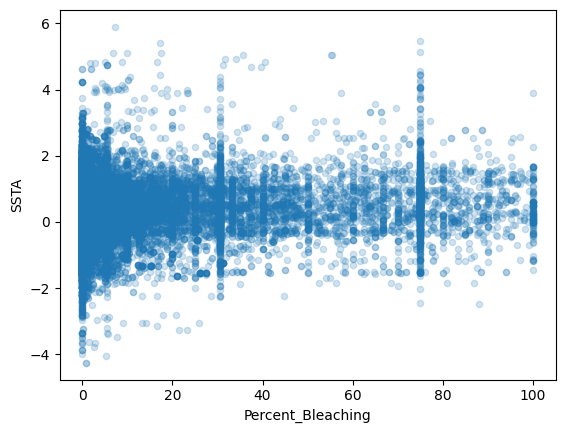

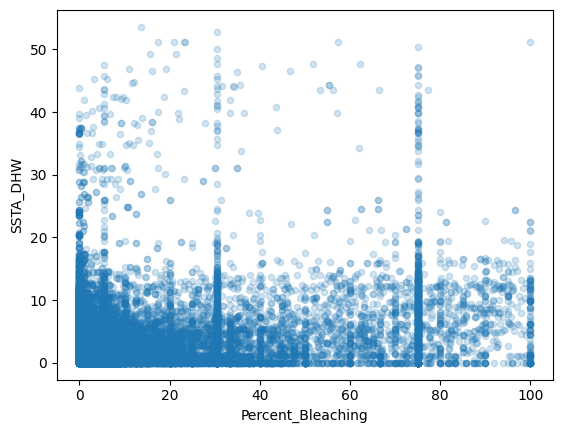

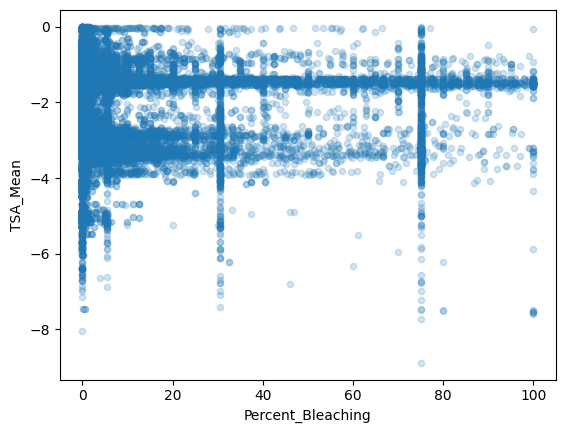

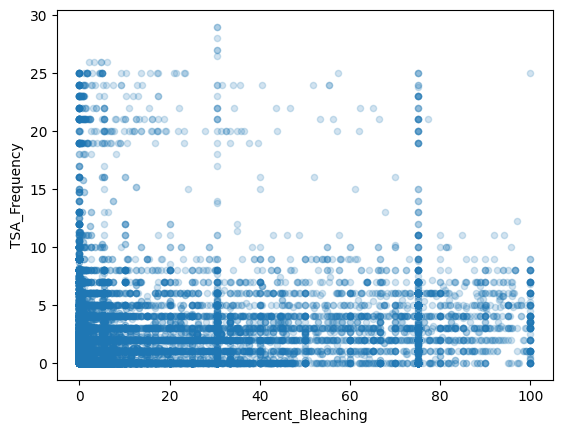

In [114]:
df_clean.plot(kind="scatter", y="Depth_m", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Distance_to_Shore", x="Percent_Bleaching", alpha=0.2)
plt.show()    
df_clean.plot(kind="scatter", y="ClimSST", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Temperature_Kelvin", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Temperature_Mean", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Temperature_Maximum", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Windspeed", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="Depth_m", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="SSTA", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="SSTA_DHW", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="TSA_Mean", x="Percent_Bleaching", alpha=0.2)
plt.show()   
df_clean.plot(kind="scatter", y="TSA_Frequency", x="Percent_Bleaching", alpha=0.2)
plt.show()   

Calculating the Correlation between features and 'Percent_Bleaching'

In [115]:
corr_matrix = df_clean.corr(numeric_only=True)
print('\n',corr_matrix["Percent_Bleaching"].sort_values(ascending=False)) 


 Percent_Bleaching      1.000000
SSTA_DHW               0.272392
Depth_m                0.165545
TSA_Frequency          0.162356
SSTA                   0.119348
Temperature_Kelvin     0.107627
Windspeed              0.054933
Latitude_Degrees       0.051453
Distance_to_Shore      0.040749
Cyclone_Frequency      0.017477
Temperature_Maximum   -0.014019
ClimSST               -0.034744
Temperature_Mean      -0.064810
TSA_Mean              -0.072845
Longitude_Degrees     -0.144262
Name: Percent_Bleaching, dtype: float64


Due to reasons, I decided to drop a few features:
- Cyclone_Frequency: With the lowest non-negative correlation score, Cyclone_Frequency has little to none noticeable impact on predicting 'Percent_Bleaching', keeping it might make the model more bloated.
- Temperature_Maximum: Like Cyclone_Frequency, it has the least impact on predictability, having negative correlation also is unnecessary with values that low.


In [116]:
df_clean = df_clean.drop(columns= ['Cyclone_Frequency', 'Temperature_Maximum'])

## Data Preprocessing

### Handling missing values.

In [117]:
df_clean.isnull().sum()

Latitude_Degrees         0
Longitude_Degrees        0
Ocean_Name               0
Distance_to_Shore        2
Exposure                 0
Depth_m               1681
Percent_Cover            0
Bleaching_Level          0
Percent_Bleaching        0
ClimSST                 95
Temperature_Kelvin     122
Temperature_Mean       106
Windspeed              111
SSTA                   122
SSTA_DHW               122
TSA_Mean               106
TSA_Frequency          122
Date                     0
dtype: int64

As there are a considerable amount of missing values, any row that is missing is replaced with it's Mean.

In [118]:
To_Impute = ['Depth_m', 'ClimSST',
              'Temperature_Kelvin', 'Temperature_Mean', 
              'Windspeed','SSTA', 'SSTA_DHW',
              'TSA_Mean', 'TSA_Frequency']
imputer = SimpleImputer(strategy='mean')
df_clean[To_Impute] = imputer.fit_transform(df_clean[To_Impute])
df_clean.isnull().sum()

Latitude_Degrees      0
Longitude_Degrees     0
Ocean_Name            0
Distance_to_Shore     2
Exposure              0
Depth_m               0
Percent_Cover         0
Bleaching_Level       0
Percent_Bleaching     0
ClimSST               0
Temperature_Kelvin    0
Temperature_Mean      0
Windspeed             0
SSTA                  0
SSTA_DHW              0
TSA_Mean              0
TSA_Frequency         0
Date                  0
dtype: int64

### Handling Outliers

In [119]:
To_Handle = ['Distance_to_Shore', 
            'Depth_m', 'ClimSST',
            'Temperature_Kelvin', 'Temperature_Mean', 
            'Windspeed',
            'SSTA', 'SSTA_DHW', 'TSA_Mean', 'TSA_Frequency']

def detect_outliers_iqr(data, columns):
    for sample in columns: 
        if pd.api.types.is_numeric_dtype(data[sample]):
                q1 = data[sample].quantile(0.25)
                q3 = data[sample].quantile(0.75)

                IQR = q3-q1
                lwr_bound = q1-(1.5*IQR)
                upr_bound = q3+(1.5*IQR)

                data = data[(data[sample] >= lwr_bound) & (data[sample] < upr_bound)]
        return data
    
df_clean = detect_outliers_iqr(df_clean, To_Handle)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28995 entries, 1 to 35044
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Latitude_Degrees    28995 non-null  float64 
 1   Longitude_Degrees   28995 non-null  float64 
 2   Ocean_Name          28995 non-null  category
 3   Distance_to_Shore   28995 non-null  float64 
 4   Exposure            28995 non-null  category
 5   Depth_m             28995 non-null  float64 
 6   Percent_Cover       28995 non-null  object  
 7   Bleaching_Level     28995 non-null  category
 8   Percent_Bleaching   28995 non-null  float64 
 9   ClimSST             28995 non-null  float64 
 10  Temperature_Kelvin  28995 non-null  float64 
 11  Temperature_Mean    28995 non-null  float64 
 12  Windspeed           28995 non-null  float64 
 13  SSTA                28995 non-null  float64 
 14  SSTA_DHW            28995 non-null  float64 
 15  TSA_Mean            28995 non-null  float

## PREPARE THE DATA

### Split training set test

In [120]:
#%% 4.2 Split training-test set and NEVER touch test set until test phase
method = 1
if method == 1: # Method 1: Randomly select 20% of data for test set. Used when data set is large
    from sklearn.model_selection import train_test_split
    train_set, test_set = train_test_split(df_clean, test_size=0.2, random_state=42) # set random_state to get the same training set all the time, 
                                                                                     # otherwise, when repeating training many times, your model may see all the data
elif method == 2: # Method 2: Stratified sampling, to remain distributions of important features, see (Geron, 2019) page 56
    # Create new feature "PRICE RANGE": the distribution we want to remain
    df_clean["Percent_Bleaching"] = pd.cut(raw_data["Percent_Bleaching"],
                                    bins=[0, 20, 40, 60, 80, 100, np.inf],
                                    #labels=["<20%", "20-40%", "40-60%", "60-80%", "80-100%", ">100%"])
                                    labels=[20,40,60,80,100]) # use numeric labels to plot histogram
    
    # Create training and test set
    from sklearn.model_selection import StratifiedShuffleSplit  
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # n_splits: no. of re-shuffling & splitting = no. of train-test sets 
                                                                                  # (if you want to run the algorithm n_splits times with different train-test set)
    for train_index, test_index in splitter.split(df_clean, df_clean["Percent_Bleaching"]): # Feature "PRICE RANGE" must NOT contain NaN
        train_set = df_clean.iloc[train_index]
        test_set = df_clean.iloc[test_index]              
    
    # See if it worked as expected
    if 1:
        df_clean["Percent_Bleaching"].hist(bins=6, figsize=(5,5)); #plt.show();
        train_set["Percent_Bleaching"].hist(bins=6, figsize=(5,5)); plt.show()

    # Remove the new feature
    #print(train_set.info())
    for _set_ in (train_set, test_set):
        #_set_.drop("income_cat", axis=1, inplace=True) # axis=1: drop cols, axis=0: drop rows
        _set_.drop(columns="Percent_Bleaching", inplace=True) 
    #print(train_set.info())
    #print(test_set.info())
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
23196 training + 5799 test examples
       Latitude_Degrees  Longitude_Degrees Ocean_Name  Distance_to_Shore  \
5050            19.9670           -87.4610   Atlantic             407.78   
11626          -16.4994          -151.7840    Pacific             953.11   
33743           12.3175           -69.1525   Atlantic              93.61   
7566            17.7854           -87.9921   Atlantic            3016.71   

        Exposure  Depth_m Percent_Cover Bleaching_Level  Percent_Bleaching  \
5050     Exposed     2.85            nd              nd                7.1   
11626    Exposed     7.00          8.12      Population                0.0   
33743  Sheltered     3.00         14.38      Population               25.0   
7566     Exposed    13.00         21.25      Population                0.0   

       ClimSST  Temperature_Kelvin  Temperature_Mean  Windspeed  SSTA  \
5050    262.15              302.55            300.81        3.0 

### Separate label from data

In [121]:
#%% 4.3 Separate labels from data, since we do not process label values
train_set_labels = train_set["Percent_Bleaching"].copy()
train_set = train_set.drop(columns = "Percent_Bleaching") 
test_set_labels = test_set["Percent_Bleaching"].copy()
test_set = test_set.drop(columns = "Percent_Bleaching") 

### Define Pipeline

In [122]:
# 4.4.1 Define ColumnSelector: a transformer for choosing columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, dataframe, labels=None):
        return self
    def transform(self, dataframe):
        return dataframe[self.feature_names].values         

num_feat_names = ['Depth_m',
                  'Temperature_Kelvin','Windspeed',
                  'SSTA','SSTA_DHW',
                  'TSA_Mean', 'TSA_Frequency'
                  ] # =list(train_set.select_dtypes(include=[np.number]))
cat_feat_names = ['Ocean_Name', 'Bleaching_Level', 'Exposure'] # =list(train_set.select_dtypes(exclude=[np.number])) 

# 4.4.2 Pipeline for categorical features
cat_pipeline = Pipeline([
    ('selector', ColumnSelector(cat_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = "NO INFO", copy=True)), # complete missing values. copy=False: imputation will be done in-place 
    ('cat_encoder', OneHotEncoder()) # convert categorical data into one-hot vectors
    ])    

# 4.4.4 Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median", copy=True)), # copy=False: imputation will be done in-place 
    ('std_scaler', StandardScaler(with_mean=True, with_std=True, copy=True)) # Scale features to zero mean and unit variance
    ])  
  
# 4.4.5 Combine features transformed by two above pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline) ])  

In [123]:
import os
import joblib

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

processed_train_set_val = full_pipeline.fit_transform(train_set)
print('\n____________ Processed feature values ____________')
print(processed_train_set_val[[0, 1, 2],:].toarray())
print(processed_train_set_val.shape)
print('We have %d numeric feature + 1 added features + 35 cols of onehotvector for categorical features.' %(len(num_feat_names)))
joblib.dump(full_pipeline, r'models/full_pipeline.pkl')


____________ Processed feature values ____________
[[-1.00486615  0.62158597 -0.83973002  0.07269593  0.55895352  0.32873403
  -0.38152965  0.          1.          0.          0.          0.
   0.          1.          1.          0.          0.        ]
 [ 0.01023285  0.27413556 -0.83973002 -0.47478046 -0.69754239  0.66314011
  -0.75052083  0.          0.          0.          1.          0.
   1.          0.          1.          0.          0.        ]
 [-0.96817582 -1.02369393  2.06053603 -0.92271568 -0.69754239  0.26371062
  -0.19703406  0.          1.          0.          0.          0.
   1.          0.          0.          1.          0.        ]]
(23196, 17)
We have 7 numeric feature + 1 added features + 35 cols of onehotvector for categorical features.


['models/full_pipeline.pkl']

## TRAIN AND EVALUATE MODELS

### MODEL 1 - LinearRegression Model

In [124]:
# 5.1 Try LinearRegression model
# 5.1.1 Training: learn a linear regression hypothesis using training data 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(processed_train_set_val, train_set_labels)
print('\n____________ LinearRegression ____________')
print('Learned parameters: ', model.coef_, model.intercept_)

# 5.1.2 Compute R2 score and root mean squared error
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse      
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
        
# 5.1.3 Predict labels for some training instances
print("\nInput data: \n", train_set.iloc[0:9])
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))

# 5.1.4 Store models to files, to compare latter
#from sklearn.externals import joblib 
import joblib # new lib
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model
store_model(model)


____________ LinearRegression ____________
Learned parameters:  [  1.36999888   0.60874298   1.31053124   0.20516701   3.98983083
   1.05616854   1.14390089   1.74806176  -2.98176833   3.77962452
   0.56374133  -3.10965928 -10.98607944  10.98607944  -0.61046052
  -0.47787053   1.08833104] 14.379069356941557

R2 score (on training data, best=1): 0.32645427642349223
Root Mean Square Error:  16.6

Input data: 
        Latitude_Degrees  Longitude_Degrees Ocean_Name  Distance_to_Shore  \
5050            19.9670           -87.4610   Atlantic             407.78   
11626          -16.4994          -151.7840    Pacific             953.11   
33743           12.3175           -69.1525   Atlantic              93.61   
7566            17.7854           -87.9921   Atlantic            3016.71   
26866           10.1742           124.9935    Pacific             110.18   
12815           -5.4764           123.7573    Pacific             422.20   
15312            5.9106           102.7098    Pacific  

### MODEL 2 - DecisionTreeRegressor

In [125]:
# Training
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(processed_train_set_val, train_set_labels)
# Compute R2 score and root mean squared error
print('\n____________ DecisionTreeRegressor ____________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
store_model(model)
# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________ DecisionTreeRegressor ____________

R2 score (on training data, best=1): 0.9688149308614749
Root Mean Square Error:  3.6

Predictions:  [ 7.1  0.  25.   0.   1.2  0.   0.   0.   0.8]
Labels:       [7.1, 0.0, 25.0, 0.0, 1.25, 0.0, 0.0, 0.0, 0.75]


### MODEL 3 - RandomForestRegressor

In [126]:
# Training (NOTE: may take time if train_set is large)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 5) # n_estimators: no. of trees
model.fit(processed_train_set_val, train_set_labels)
# Compute R2 score and root mean squared error
print('\n____________ RandomForestRegressor ____________')
r2score, rmse = r2score_and_rmse(model, processed_train_set_val, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
store_model(model)      
# Predict labels for some training instances
#print("Input data: \n", train_set.iloc[0:9])
print("\nPredictions: ", model.predict(processed_train_set_val[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________ RandomForestRegressor ____________

R2 score (on training data, best=1): 0.9065331808925503
Root Mean Square Error:  6.2

Predictions:  [ 7.9  0.  15.   0.   1.1  1.5  0.   0.1  0.8]
Labels:       [7.1, 0.0, 25.0, 0.0, 1.25, 0.0, 0.0, 0.0, 0.75]


### MODEL 4 - PolinomialRegression

In [127]:
# NOTE: polinomial regression can be treated as (multivariate) linear regression where high-degree features x1^2, x2^2, x1*x2... are seen as new features x3, x4, x5... 
# hence, to do polinomial regression, we add high-degree features to the data, then call linear regression
# 5.4.1 Training. NOTE: may take a while 
from sklearn.preprocessing import PolynomialFeatures
poly_feat_adder = PolynomialFeatures(degree = 2) # add high-degree features to the data
train_set_poly_added = poly_feat_adder.fit_transform(processed_train_set_val)
new_training = 10
if new_training:
    model = LinearRegression()
    model.fit(train_set_poly_added, train_set_labels)
    store_model(model, model_name = "PolinomialRegression")      
else:
    model = load_model("PolinomialRegression")
# 5.4.2 Compute R2 score and root mean squared error
print('\n____________ Polinomial regression ____________')
r2score, rmse = r2score_and_rmse(model, train_set_poly_added, train_set_labels)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse.round(decimals=1))
# 5.4.3 Predict labels for some training instances
print("\nPredictions: ", model.predict(train_set_poly_added[0:9]).round(decimals=1))
print("Labels:      ", list(train_set_labels[0:9]))


____________ Polinomial regression ____________

R2 score (on training data, best=1): 0.4362361365163313
Root Mean Square Error:  15.2

Predictions:  [18.4  0.5  1.1  9.6 -1.9  7.4  0.6 -0.6  5.4]
Labels:       [7.1, 0.0, 25.0, 0.0, 1.25, 0.0, 0.0, 0.0, 0.75]


## Evaluate with K-fold cross validation

In [134]:
os.makedirs('saved_objects', exist_ok=True)

from sklearn.model_selection import cross_val_score 
print('\n____________ K-fold cross validation ____________')


from sklearn.model_selection import KFold, StratifiedKFold
# NOTE: 
#   + If data labels are float, cross_val_score use KFold() to split cv data.
#   + KFold randomly splits data, hence does NOT ensure data splits are the same (only StratifiedKFold may ensure that)
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator: just a try to persist data splits (hopefully)

# Evaluate LinearRegression
model_name = "LinearRegression" 
model = LinearRegression()             
nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-nmse_scores)
joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
print("LinearRegression rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

# Evaluate DecisionTreeRegressor
model_name = "DecisionTreeRegressor" 
model = DecisionTreeRegressor()
nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-nmse_scores)
joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
print("DecisionTreeRegressor rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

# Evaluate RandomForestRegressor
model_name = "RandomForestRegressor" 
model = RandomForestRegressor(n_estimators = 5)
nmse_scores = cross_val_score(model, processed_train_set_val, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-nmse_scores)
joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
print("RandomForestRegressor rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

# Evaluate Polinomial regression
model_name = "PolinomialRegression" 
model = LinearRegression()
nmse_scores = cross_val_score(model, train_set_poly_added, train_set_labels, cv=cv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-nmse_scores)
joblib.dump(rmse_scores,'saved_objects/' + model_name + '_rmse.pkl')
print("Polinomial regression rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

#Load the RMSE
model_name = "LinearRegression" 
rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
print("\nLinearRegression rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

model_name = "DecisionTreeRegressor" 
rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
print("DecisionTreeRegressor rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

model_name = "RandomForestRegressor" 
rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
print("RandomForestRegressor rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')

model_name = "PolinomialRegression" 
rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
print("Polinomial regression rmse: ", rmse_scores.round(decimals=1))
print("Avg. rmse: ", mean(rmse_scores.round(decimals=1)),'\n')



____________ K-fold cross validation ____________
LinearRegression rmse:  [16.3 16.6 16.8 16.3 16.9]
Avg. rmse:  16.580000000000002 

DecisionTreeRegressor rmse:  [14.2 14.1 14.5 14.2 14.8]
Avg. rmse:  14.36 

RandomForestRegressor rmse:  [12.1 12.4 12.6 11.9 12.7]
Avg. rmse:  12.34 

Polinomial regression rmse:  [14.9 15.4 15.5 14.8 15.7]
Avg. rmse:  15.26 


LinearRegression rmse:  [16.3 16.6 16.8 16.3 16.9]
Avg. rmse:  16.580000000000002 

DecisionTreeRegressor rmse:  [14.2 14.1 14.5 14.2 14.8]
Avg. rmse:  14.36 

RandomForestRegressor rmse:  [12.1 12.4 12.6 11.9 12.7]
Avg. rmse:  12.34 

Polinomial regression rmse:  [14.9 15.4 15.5 14.8 15.7]
Avg. rmse:  15.26 



Contributions (Personal)

- Minh: 25
- Lam: 20
- Tam: 20
- Ngan: 20
- Loc: 15